In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Asher\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [4]:
columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("twitter_training.csv", names=columns,header=None)

In [5]:
data.head()

,Id,Entity,Target,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df = data[["Text","Target"]]

In [7]:
df.head()

,Text,Target
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [8]:
df.shape

(74682, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    73996 non-null  object
 1   Target  74682 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [10]:
df= df.drop_duplicates()

<AxesSubplot:xlabel='Target', ylabel='count'>

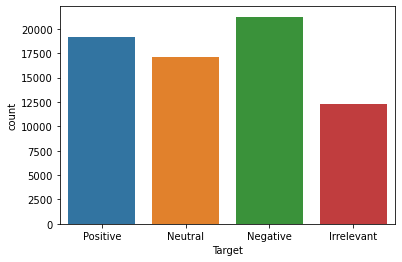

In [11]:
sns.countplot(x="Target",data=df)

In [12]:
sentiment = []

for i in df["Target"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df["Sentiment"] = sentiment

In [13]:
df.head()

,Text,Target,Sentiment
0,im getting on borderlands and i will murder yo...,Positive,1
1,I am coming to the borders and I will kill you...,Positive,1
2,im getting on borderlands and i will kill you ...,Positive,1
3,im coming on borderlands and i will murder you...,Positive,1
4,im getting on borderlands 2 and i will murder ...,Positive,1


In [14]:
stop_words = set(stopwords.words("english"))

In [15]:
df["Text"] = df["Text"].str.replace("\d","")

In [16]:
def cleaner(data):
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [17]:
df["Text"] = df["Text"].apply(cleaner)
df["Text"].head()

0     im get borderland murder
1             come border kill
2       im get borderland kill
3    im come borderland murder
4     im get borderland murder
Name: Text, dtype: object

In [18]:
df["Text"]=df["Text"].str.replace("im","")
df["Text"].head()

0      get borderland murder
1           come border kill
2        get borderland kill
3     come borderland murder
4      get borderland murder
Name: Text, dtype: object

In [19]:
rare_words = pd.Series(" ".join(df["Text"]).split()).value_counts()
rare_words

game           10787
play            6822
get             5567
like            5153
go              4216
               ...  
feirjvaezh         1
odiou              1
assumpt            1
likey              1
matchsearch        1
Length: 22234, dtype: int64

In [20]:
rare_words = rare_words[rare_words <= 2]

In [21]:
df["Text"] = df["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

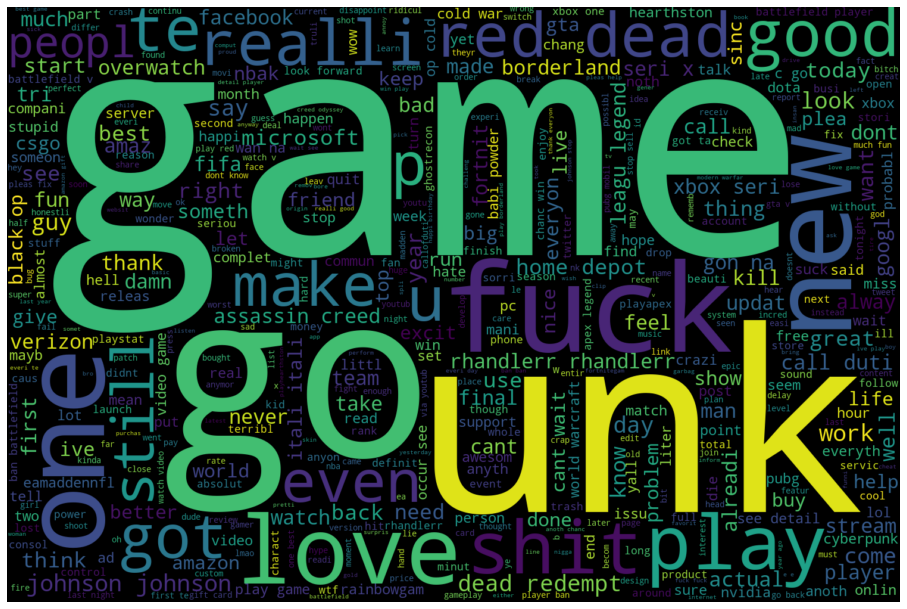

In [22]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="black",max_words=500, width=1500, height=1000).generate(' '.join(df['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [24]:
X = df["Text"]
y = df["Sentiment"]

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

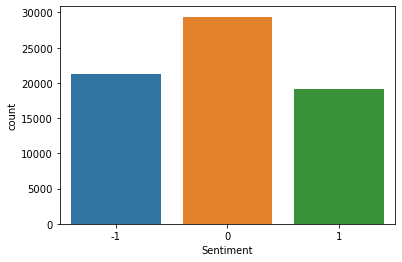

In [25]:
sns.countplot(y,data=df)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42,stratify = y)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [29]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<48841x14108 sparse matrix of type '<class 'numpy.int64'>'
	with 480354 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn = KNeighborsClassifier()

In [32]:
knn_model = knn.fit(X_train_count,y_train)

In [33]:
knn_pred = knn_model.predict(X_test_count)
knn_train_pred = knn_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84      6371
           0       0.86      0.82      0.84      8819
           1       0.81      0.82      0.82      5742

    accuracy                           0.83     20932
   macro avg       0.83      0.84      0.83     20932
weighted avg       0.84      0.83      0.83     20932

X Train
              precision    recall  f1-score   support

          -1       0.92      0.94      0.92     14867
           0       0.93      0.92      0.92     20577
           1       0.92      0.91      0.91     13397

    accuracy                           0.92     48841
   macro avg       0.92      0.92      0.92     48841
weighted avg       0.92      0.92      0.92     48841



<AxesSubplot:>

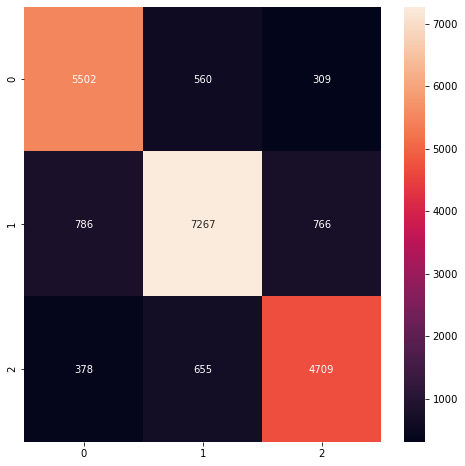

In [38]:
print("X Test")
print(classification_report(y_test,knn_pred))
print("X Train")
print(classification_report(y_train,knn_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True,fmt = "d")

In [39]:
pred_df = pd.DataFrame({"KNN accuracy score": [accuracy_score(y_test,knn_pred)]})

In [40]:
pred_df

,KNN accuracy score
0,0.834989
